In [1]:
# import example model
from examples.battery_model import *
from electric_emission_cost import costs

# Pyomo Example

### Specify dynamics model

Begin by specifying the dynamics model as a pyomo Concrete model. More information about the battery model is contained in `examples/battery_model.py`

In [2]:
# Define the parameters for the battery model
battery_params = {
    "start_date": "2022-07-01 00:00:00",
    "end_date": "2022-08-01 00:00:00",
    "timestep": 0.25,   # 15 minutes defined in hours
    "rte": 0.86,
    "energycapacity": 100,
    "powercapacity": 50,
    "soc_min": 0.05,
    "soc_max": 0.95,
    "soc_init": 0.5,
}

# Create a sample baseload profile based on a sine wave
baseload = np.sin(np.linspace(0, 4 * np.pi, 96))*100 + 1000 + np.random.normal(0, 10, 96)
# baseload = np.random.normal(1000, 20, size=96)

# Create an instance of the BatteryOpt class
battery = BatteryPyomo(battery_params, baseload, baseload_repeat=True)

# create the model on the instance battery
battery.create_model()

In [3]:
baseload

array([1012.91525217, 1014.42772696, 1026.82358787, 1046.97752679,
       1065.32270774, 1074.73133173, 1063.71120267, 1078.95730304,
       1086.98509639, 1103.01150948, 1097.55926888, 1102.39641422,
       1107.97620134, 1108.36360575, 1073.54630645, 1089.73695104,
       1099.14187813, 1080.92711371, 1071.47817597, 1066.39529759,
       1038.62766986, 1027.78601034, 1018.4916192 ,  996.67984053,
        997.45371787,  983.31393923,  966.2324522 ,  965.81141354,
        936.02992794,  953.81343512,  932.03124336,  928.99403757,
        927.02466731,  899.13053505,  906.08632092,  896.7430717 ,
        898.68253399,  903.87808488,  910.36042683,  924.51225872,
        912.14187617,  923.73905049,  947.20148584,  905.72864302,
        950.90938354,  965.46049777,  966.28335181,  988.67912791,
       1000.70500895, 1040.4562116 , 1007.32731416, 1036.31403035,
       1064.14162062, 1059.45459418, 1055.08736841, 1085.20064909,
       1090.53069362, 1106.37364759, 1094.19039869, 1085.61244

### Retrieve and add tariffs

Retrieve example tariff sheet contained in electric_emission_cost and read it as a dataframe


In [4]:
path_to_tariffsheet = "../electric_emission_cost/data/tariff.csv"
rate_df = pd.read_csv(path_to_tariffsheet, sep=",")
rate_df

,utility,type,assessed,period,basic_charge_limit (imperial),basic_charge_limit (metric),month_start,month_end,hour_start,hour_end,weekday_start,weekday_end,charge (imperial),charge (metric),units,Notes
0,electric,customer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,666.650000,666.650000,$/month,https://www.pnm.com/documents/28767612/2877507...
1,electric,demand,NaN,NaN,0.0,0.0,1.0,12.0,0.0,8.0,0.0,4.0,19.790000,19.790000,$/kW,NaN
2,electric,demand,NaN,NaN,0.0,0.0,1.0,12.0,8.0,20.0,0.0,4.0,28.440000,28.440000,$/kW,NaN
3,electric,demand,NaN,NaN,0.0,0.0,1.0,12.0,20.0,24.0,0.0,4.0,19.790000,19.790000,$/kW,NaN
4,electric,demand,NaN,NaN,0.0,0.0,1.0,12.0,0.0,24.0,5.0,6.0,19.790000,19.790000,$/kW,NaN
5,electric,energy,NaN,NaN,0.0,0.0,1.0,5.0,0.0,5.0,0.0,4.0,0.018994,0.018994,$/kWh,NaN
6,electric,energy,NaN,NaN,0.0,0.0,1.0,5.0,5.0,8.0,0.0,4.0,0.026250,0.026250,$/kWh,NaN
7,electric,energy,NaN,NaN,0.0,0.0,1.0,5.0,8.0,17.0,0.0,4.0,0.015203,0.015203,$/kWh,NaN
8,electric,energy,NaN,NaN,0.0,0.0,1.0,5.0,17.0,20.0,0.0,4.0,0.026250,0.026250,$/kWh,NaN
9,electric,energy,NaN,NaN,0.0,0.0,1.0,5.0,20.0,24.0,0.0,4.0,0.018994,0.018994,$/kWh,NaN


Using the start and end time within the battery model and the rate dataframe, create a dictionary of charges. 

*Note: the start and end time must be datetime objects.*

In [5]:
# get the charge dictionary
charge_dict = costs.get_charge_dict(
    battery.start_dt, battery.end_dt, rate_df, resolution="15m"
)
charge_dict

{'electric_customer_0_2022-07-01_2022-07-31_0': array([666.65]),
 'electric_energy_0_2022-07-01_2022-07-31_0': array([0., 0., 0., ..., 0., 0., 0.], shape=(2976,)),
 'electric_energy_1_2022-07-01_2022-07-31_0': array([0., 0., 0., ..., 0., 0., 0.], shape=(2976,)),
 'electric_energy_2_2022-07-01_2022-07-31_0': array([0., 0., 0., ..., 0., 0., 0.], shape=(2976,)),
 'electric_energy_3_2022-07-01_2022-07-31_0': array([0., 0., 0., ..., 0., 0., 0.], shape=(2976,)),
 'electric_energy_4_2022-07-01_2022-07-31_0': array([0., 0., 0., ..., 0., 0., 0.], shape=(2976,)),
 'electric_energy_5_2022-07-01_2022-07-31_0': array([0.0254538, 0.0254538, 0.0254538, ..., 0.       , 0.       ,
        0.       ], shape=(2976,)),
 'electric_energy_6_2022-07-01_2022-07-31_0': array([0., 0., 0., ..., 0., 0., 0.], shape=(2976,)),
 'electric_energy_7_2022-07-01_2022-07-31_0': array([0., 0., 0., ..., 0., 0., 0.], shape=(2976,)),
 'electric_energy_8_2022-07-01_2022-07-31_0': array([0., 0., 0., ..., 0., 0., 0.], shape=(297

In [6]:
# this can also be done in a dataframe format that drops all the unnecessary columns
charge_df = costs.get_charge_df(battery.start_dt, battery.end_dt, rate_df, )
charge_df.head()

,DateTime,electric_energy_5_2022-07-01_2022-07-31_0,electric_energy_6_2022-07-01_2022-07-31_0,electric_energy_7_2022-07-01_2022-07-31_0,electric_energy_8_2022-07-01_2022-07-31_0,electric_energy_15_2022-07-01_2022-07-31_0,electric_demand_0_2022-07-01_2022-07-31_0,electric_demand_1_2022-07-01_2022-07-31_0,electric_demand_2_2022-07-01_2022-07-31_0,electric_demand_3_2022-07-01_2022-07-31_0
0,2022-07-01 00:00:00,0.025454,0.0,0.0,0.0,0.0,19.79,0.0,0.0,0.0
1,2022-07-01 00:15:00,0.025454,0.0,0.0,0.0,0.0,19.79,0.0,0.0,0.0
2,2022-07-01 00:30:00,0.025454,0.0,0.0,0.0,0.0,19.79,0.0,0.0,0.0
3,2022-07-01 00:45:00,0.025454,0.0,0.0,0.0,0.0,19.79,0.0,0.0,0.0
4,2022-07-01 01:00:00,0.025454,0.0,0.0,0.0,0.0,19.79,0.0,0.0,0.0


### Add cost rules to model

Set up `consumption_data_dict` to track the variable in the model that represents the total power consumption.

In [7]:
# this example tariff only has electric utility types so we do not pass the gas key
consumption_data_dict = {"electric": battery.model.net_facility_load}

Using the baseline consumption and the rules of the rate structure, the package will find the charge categories that are relevant for the simulation time frame. It will also automatically build constraints to calculate electricity cost.

In [8]:
battery.model.electricity_cost, battery.model = costs.calculate_cost(
            charge_dict,
            consumption_data_dict,
            resolution="15m",
            prev_demand_dict=None,
            prev_consumption_dict=None,
            consumption_estimate=0,
            desired_utility="electric",
            desired_charge_type=None,
            model=battery.model,
        )

### Create the objective on the model and solve

In [9]:
# create an attribute objective based on the electricity cost
battery.model.objective = Objective(
            expr=battery.model.electricity_cost,
            sense=minimize,
        )

In [ ]:
# use the glpk solver to solve the model - (any pyomo-supported LP solver will work here)
solver = SolverFactory("glpk")
results = solver.solve(battery.model, tee=False) # turn tee=True to see solver output

### Visualize Output

Visualize charge arrays

In [21]:
# create a subset of the charge_df for energy and demand charges
energy_charge_df = charge_df.filter(like="energy")
demand_charge_df = charge_df.filter(like="demand")

# sum across all energy charges
total_energy_charge = energy_charge_df.sum(axis=1)

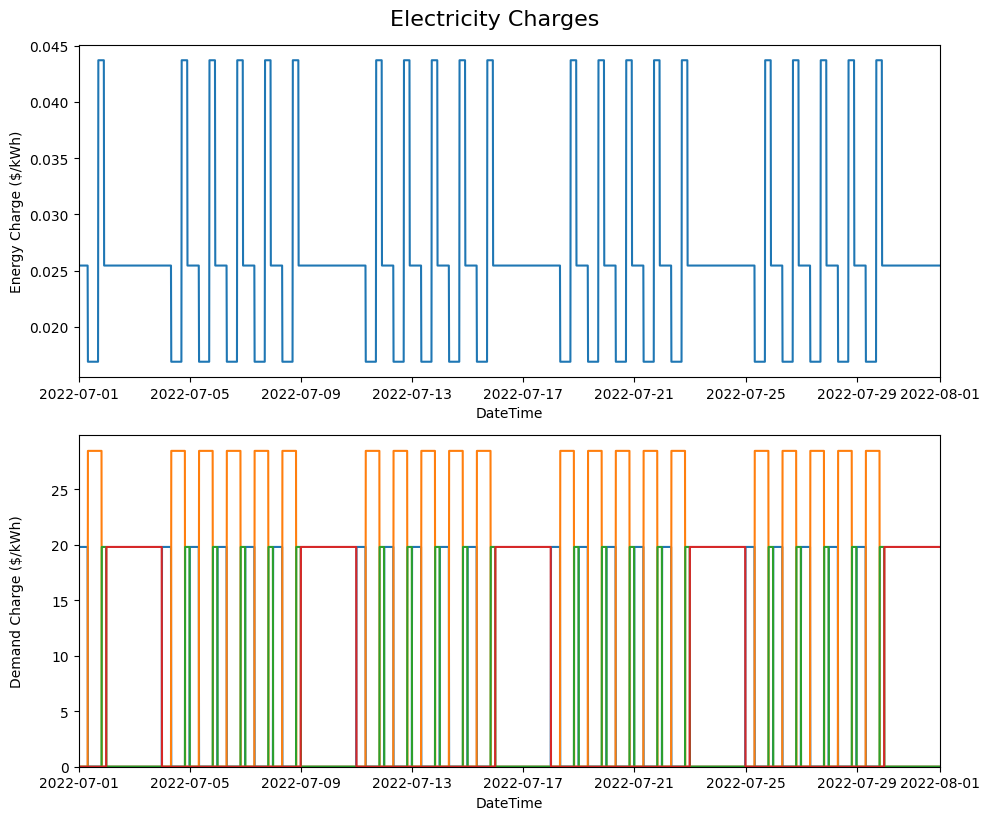

In [22]:
# plot 
import matplotlib.pyplot as plt
fig, ax= plt.subplots(2, 1, figsize=(10, 8))
# plot the energy charges
ax[0].plot(charge_df["DateTime"], total_energy_charge)
ax[0].set(xlabel="DateTime", ylabel="Energy Charge ($/kWh)", xlim=(battery.start_dt, battery.end_dt))

# plot the demand charges
ax[1].plot(charge_df["DateTime"], demand_charge_df)
ax[1].set(xlabel="DateTime", ylabel="Demand Charge ($/kWh)", xlim=(battery.start_dt, battery.end_dt), ylim=[0,None])

fig.align_ylabels()
fig.tight_layout()
fig.suptitle("Electricity Charges",y=1.02, fontsize=16)
plt.show()


Visualize model outputs

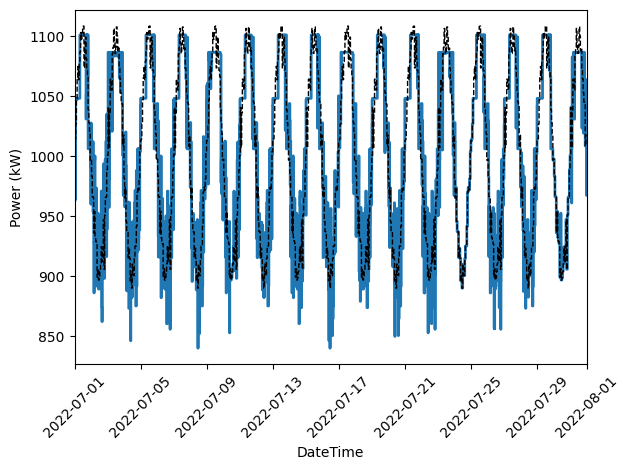

In [23]:
net_load = np.array([battery.model.net_facility_load[t].value for t in battery.model.t])
baseload = np.array([battery.model.baseload[t] for t in battery.model.t])

fig, ax= plt.subplots()
ax.step(charge_df["DateTime"], net_load, color="C0", lw=2, label="Net Load")
ax.step(charge_df["DateTime"], baseload, color="k", lw=1, ls='--', label="Baseload")
ax.set(xlabel="DateTime", ylabel="Power (kW)", xlim=(battery.start_dt, battery.end_dt))
plt.xticks(rotation=45)
fig.tight_layout()

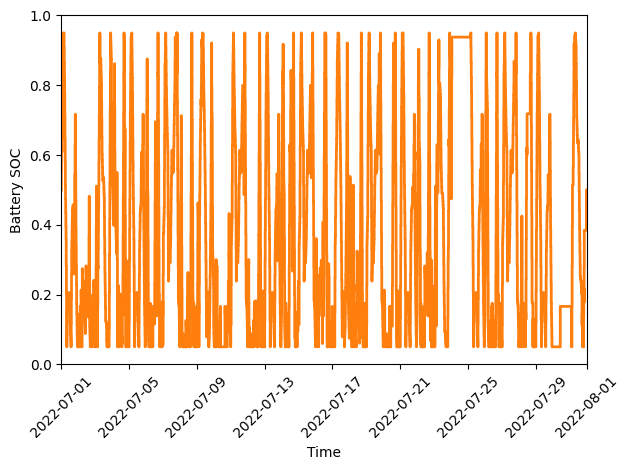

In [24]:
# plot the battery charge
battery_charge = np.array([battery.model.soc[t].value for t in battery.model.t])
fig, ax = plt.subplots()
ax.step(charge_df["DateTime"], battery_charge, color="C1", lw=2, label="Battery SOC")
ax.set(xlabel="Time", ylabel="Battery SOC", ylim=[0,1], xlim=(battery.start_dt, battery.end_dt))
plt.xticks(rotation=45)
fig.tight_layout()

We can also just pass the numpy arrays to calculate costs to get total cost without a model or any optimization. 

In [30]:
# pass numpy arrays for baseload and net_load (with battery) to the calculate_cost function
baseline_electricity_cost, _ = costs.calculate_cost(charge_dict = charge_dict,
                                consumption_data_dict = {"electric": baseload},
                                resolution="15m",
                                prev_demand_dict=None,
                                prev_consumption_dict=None,
                                consumption_estimate=0,
                                desired_utility="electric",
                                desired_charge_type=None,
                                model=None)

optimized_electricity_cost, _ = costs.calculate_cost(charge_dict = charge_dict,
                                consumption_data_dict = {"electric": net_load},
                                resolution="15m",
                                prev_demand_dict=None,
                                prev_consumption_dict=None,
                                consumption_estimate=0,
                                desired_utility="electric",
                                desired_charge_type=None,
                                model=None)

print(f"Baseline Electricity Cost: ${baseline_electricity_cost:.2f}")
print(f"Optimized Electricity Cost: ${optimized_electricity_cost:.2f}")


Baseline Electricity Cost: $115566.70
Optimized Electricity Cost: $113384.23
